In [2]:
import numpy as np
import scipy as sc
from scipy import stats
from scipy.stats import bootstrap
import matplotlib.pyplot as plt
from fontsettings import set_font_settings

In [3]:
set_font_settings()

### 2 Сравнение групп платящих игроков
-------------------------------------------
В мобильной игре около 10% игроков совершает платежи в первый месяц с момента 
установки игры (база расчета - 500 игроков). 
Геймдизайнеры разработали обновление которое по их экспертной оценке должно 
увеличить процент плательщиков с 10% до 11%. Цель эксперимента - подтвердить или 
опровергнуть их гипотезу.
Геймдизайнеры разработали обновление которое по их экспертной оценке должно 
увеличить процент плательщиков с 10% до 11%. Цель эксперимента - подтвердить или 
опровергнуть их гипотезу.
1. Опишите оптимальный по вашему мнению дизайн эксперимента
2. Рассчитайте длительность эксперимента при условии что каждый день в игру 
приходит около 100 новых игроков.
3. Самостоятельно сгенерируйте датасет с около 10% плательщиков (контроль) и 
рассчитайте 95% HDI / CI.
4. Сгенерируйте несколько вариантов экспериментальной группы (хуже, лучше, без 
эффекта), рассчитайте силу эффекта, HDI / CI и ваши выводы для каждого 
варианта.
5. Решите задачу 2 разными подходами: frequentist / bayesian
Необходимо все ответы сопроводить комментариями почему вы выбрали ту или иную 
методику расчета, алгоритм и т.д

### Решение (частотный подход):
1. Рандомизированное разделение пользователей на две группы: тестовою и контрольную. Пользователи в первой категории получат экспериментальную версию продукта, а пользователи второй — обычную.

2. Расчет длительности эксперимента:

In [4]:
def calc_sample_size(bcr, bcr_, alpha=0.05, beta=0.2):
    """
    Calculcate sample size for ab-test with required
    first and second order errors
    
    Parameters
    ----------
    bcr : real number
        basic conversion rate
    bcr_ : real number
        basic conversion rate after changes
    alpha : real number
        first order error
    beta : real number
        second order error

    Returns
    -------
    n_elements : real number
        required sample size
    """
    distr = stats.norm()
    # quantille values
    z_halfalpha = distr.ppf(1 - alpha / 2)
    z_beta = distr.ppf(1 - beta)

    # minimum detectable effect
    mde = bcr_ - bcr
    part1 = z_halfalpha * np.sqrt(2 * bcr * (1 - bcr))
    part2 = z_beta * np.sqrt(bcr * (1 - bcr) + bcr_ * (1 - bcr_))
    n_elements = np.power((part1 + part2) / mde, 2)
    # round to the nearest whole number
    n_elements = int(n_elements)
    return n_elements

In [5]:
def calc_duration(required_size, daily_inflow):
    """
    Calculate the test duration 
    """
    n_days = int(required_size / daily_inflow)
    return n_days

In [6]:
# conversions rate
bcr_ = 0.11
bcr = 0.1
# daily_inflow
daily_inflow = 100
# required errors
alpha, beta = 0.05, 0.1

n_players = calc_sample_size(bcr, bcr_, alpha, beta)
n_players_total = 2 * n_players
n_days = calc_duration(n_players, daily_inflow)

In [7]:
print(f'Required number of players for each group: {n_players}')
print(f'Required test duration: {n_days} days')

Required number of players for each group: 19239
Required test duration: 192 days


3. Самостоятельно сгенерируйте датасет с около 10% плательщиков (контроль) и рассчитайте 95% HDI / CI.

In [8]:
class Players:

    def __init__(self, bcr):
        self.bcr = bcr

    
    def rvs(self, n_players):
        np.random.seed(42)
        sample_tmp = np.random.binomial(1, self.bcr, n_players)
        self.n_players = n_players
        self.n_payers = np.sum(sample_tmp)
        self.a, self.b = self.n_payers + 1, n_players - self.n_payers + 1
        self.distr_apriori = stats.beta(self.a, self.b)
        self.sample = self.distr_apriori.rvs(n_players)

    
    def ci(self, alpha):
        self.ci_lb = stats.beta.ppf(alpha/2, self.n_payers, self.n_players-self.n_payers+1)
        self.ci_ub = stats.beta.ppf(1-(alpha/2), self.n_payers+1, self.n_players-self.n_payers)
        return self.ci_lb, self.ci_ub

In [9]:
# fix the seed value
np.random.seed(42)

# payers and non-payers
players = Players(bcr)
players.rvs(n_players_total)

print(f'The part of paying players is: {np.round(players.n_payers / players.n_players, 4)}')

# credible interval bounds
ci_lb, ci_ub = players.ci(alpha)

The part of paying players is: 0.0995


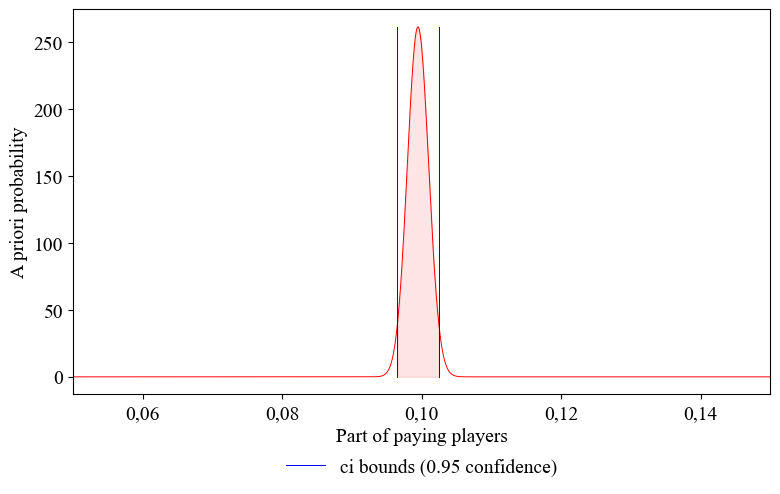

In [10]:
pp = np.linspace(0, 1, 10001)

# plot the result
fig, ax = plt.subplots(figsize=(9, 5))
dmax = players.distr_apriori.pdf(pp).max()
ax.plot(pp, players.distr_apriori.pdf(pp), lw=0.7, color='r')
# credible interval bounds
ax.plot([ci_lb, ci_lb], [0, dmax], lw=0.7, color='b', label=f'ci bounds ({1-alpha} confidence)')
ax.plot([ci_ub, ci_ub], [0, dmax], lw=0.7, color='b')
ax.fill_between(pp, players.distr_apriori.pdf(pp), where = (pp > ci_lb) & (pp < ci_ub), color='r', alpha=0.1)

# set settings
ax.set(xlabel='Part of paying players', ylabel='A priori probability', xlim=(0.05, 0.15));
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=2, frameon=False);

In [11]:
print(f'Credible interval is: ({np.round(ci_lb, 4)}, {np.round(ci_ub, 4)}) with confidence probability equal to {1 - alpha}')

Credible interval is: (0.0965, 0.1025) with confidence probability equal to 0.95


4. Сгенерируйте несколько вариантов экспериментальной группы (хуже, лучше, без эффекта), рассчитайте силу эффекта, HDI / CI и ваши выводы для каждого варианта.

In [12]:
control_players = Players(bcr)
control_players.rvs(n_players)

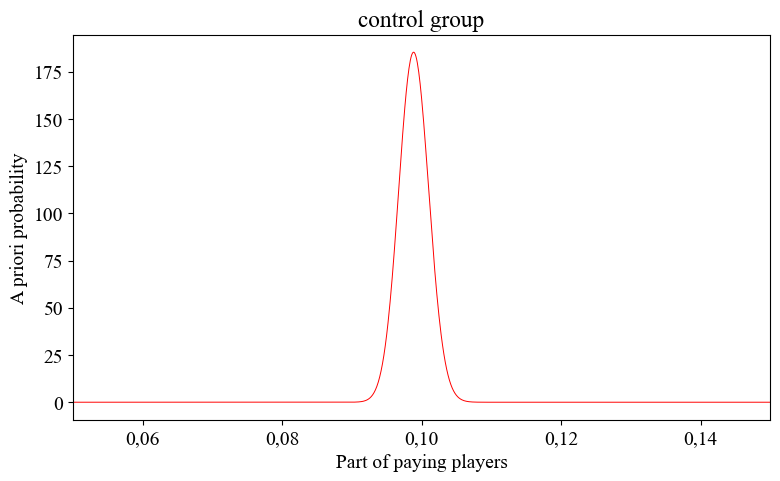

In [13]:
pp = np.linspace(0, 1, 10001)

# plot the result
fig, ax = plt.subplots(figsize=(9, 5))
dmax = control_players.distr_apriori.pdf(pp).max()
ax.plot(pp, control_players.distr_apriori.pdf(pp), lw=0.7, color='r')

# plot settings
ax.set(xlabel='Part of paying players', ylabel='A priori probability', xlim=(0.05, 0.15));
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=2, frameon=False);
plt.title('control group');

    4.1 Хуже

In [14]:
bcr_bad = 0.03
bad_test_players = Players(bcr_bad)
bad_test_players.rvs(n_players)

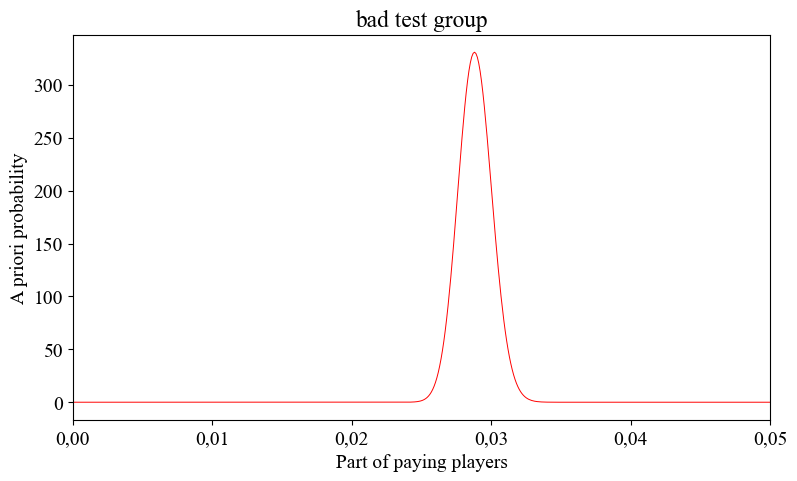

In [15]:
pp = np.linspace(0, 1, 10001)

# plot the result
fig, ax = plt.subplots(figsize=(9, 5))
dmax = bad_test_players.distr_apriori.pdf(pp).max()
ax.plot(pp, bad_test_players.distr_apriori.pdf(pp), lw=0.7, color='r')

# plot settings
ax.set(xlabel='Part of paying players', ylabel='A priori probability', xlim=(0, 0.05));
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=2, frameon=False);
plt.title('bad test group');

    4.2 Без изменений

In [16]:
bcr_equal = 0.1
equal_test_players = Players(bcr_equal)
equal_test_players.rvs(n_players)

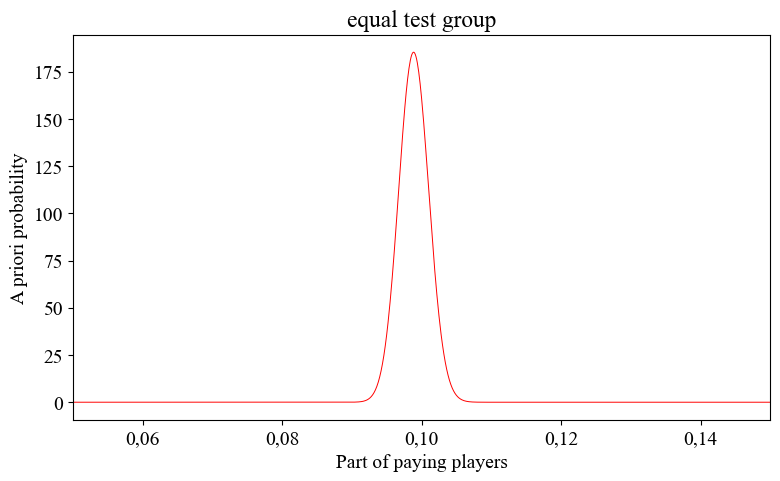

In [17]:
pp = np.linspace(0, 1, 10001)

# plot the result
fig, ax = plt.subplots(figsize=(9, 5))
dmax = equal_test_players.distr_apriori.pdf(pp).max()
ax.plot(pp, equal_test_players.distr_apriori.pdf(pp), lw=0.7, color='r')

# plot settings
ax.set(xlabel='Part of paying players', ylabel='A priori probability', xlim=(0.05, 0.15));
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=2, frameon=False);
plt.title('equal test group');

    4.3 Лучше

In [18]:
bcr_best = 0.2
best_test_players = Players(bcr_best)
best_test_players.rvs(n_players)

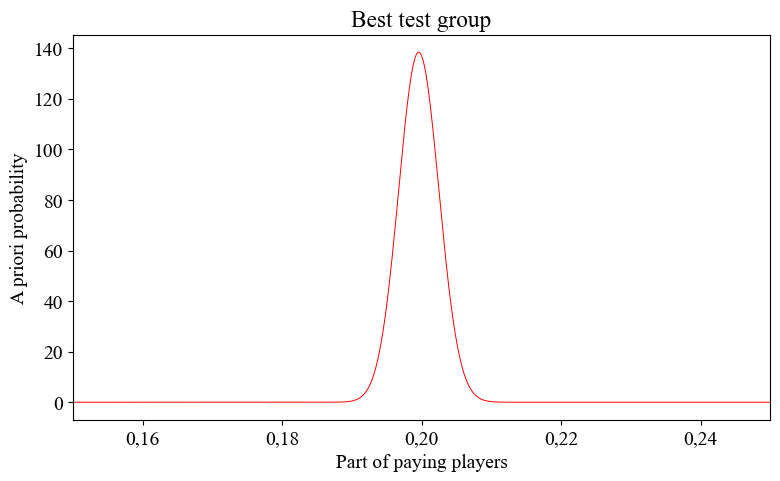

In [19]:
pp = np.linspace(0, 1, 10001)

# plot the result
fig, ax = plt.subplots(figsize=(9, 5))
dmax = best_test_players.distr_apriori.pdf(pp).max()
ax.plot(pp, best_test_players.distr_apriori.pdf(pp), lw=0.7, color='r')

# plot settings
ax.set(xlabel='Part of paying players', ylabel='A priori probability', xlim=(0.15, 0.25));
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=2, frameon=False);
plt.title('Best test group');

In [20]:
def mean_difference(group1, group2, axis=-1):
    mean1 = np.mean(group1, axis=axis)
    mean2 = np.mean(group2, axis=axis)
    return mean1 - mean2

def bootstrap_ci(group1, group2, alpha):
    rng = np.random.default_rng()
    data = (group1, group2)
    res = bootstrap(data, mean_difference, confidence_level=1-alpha,
                random_state=rng)
    return res

In [21]:
control = control_players.sample
bad = bad_test_players.sample
equal = equal_test_players.sample
best = best_test_players.sample

Вычисление доверительных интервалов для разницы средних значений

best:  ConfidenceInterval(low=0.10067528286332678, high=0.10077639617249744)
best p-value:  0.0
bad:  ConfidenceInterval(low=-0.07009703186288009, high=-0.07002763733273183)
bad p-value:  1.0
equal:  ConfidenceInterval(low=-4.236970998563234e-05, high=4.3109529411722364e-05)
equal p-value:  0.5035022644694327


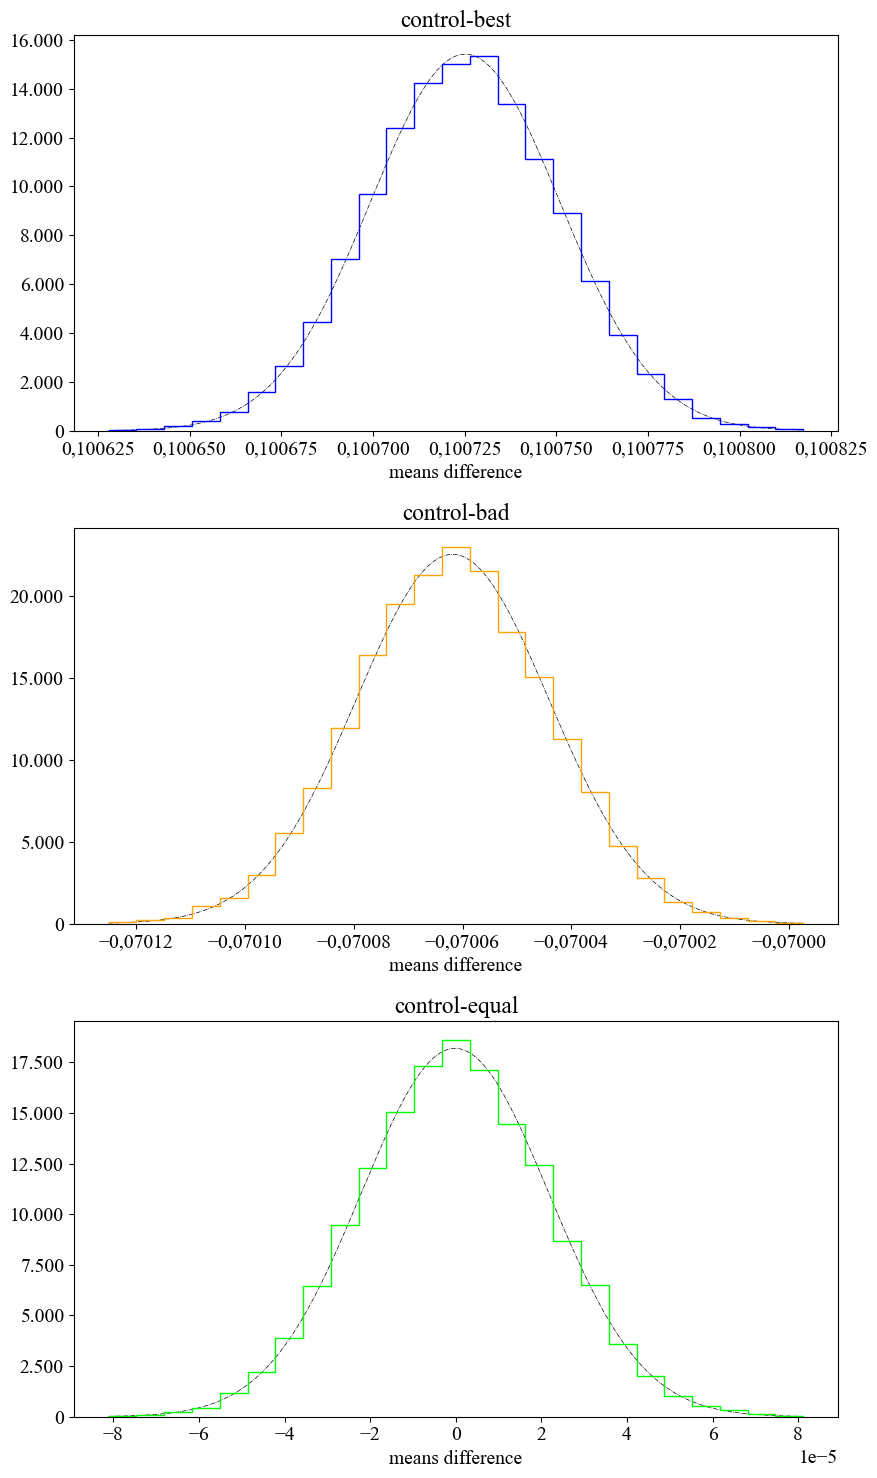

In [37]:
# bootstrap confidence intervals for mean difference
groups = {"best": best,
          "bad": bad,
          "equal": equal}

fig, ax = plt.subplots(len(groups.items()), 1, figsize=(9, 15),)
counter = 0
col_gen = iter(['b', 'orange', '#00FF00'])
for label, group in groups.items():
    res = bootstrap_ci(group, control, alpha)
    
    pp = np.linspace(res.bootstrap_distribution.min(),
                     res.bootstrap_distribution.max(),
                     1001)
    param = stats.norm.fit(res.bootstrap_distribution)
    distr = stats.norm(*param)
    print(f'{label}: ', res.confidence_interval)
    print(f'{label} p-value: ', distr.cdf(0))
    ax[counter].plot(pp, distr.pdf(pp), lw=0.5, color='k', linestyle='-.')
    ax[counter].hist(res.bootstrap_distribution, bins=25, histtype='step', color=next(col_gen), density=True)
    ax[counter].set_title(f'control-{label}');
    ax[counter].set(xlabel='means difference');
    fig.tight_layout()
    counter += 1

#### Выводы:
1. Группа $best$ показывает статистически значимое положительное отличие среднего числа платящих пользователей. Основная гипотеза о том, что разница средних меньше или равна нулю справедлива с вероятностью стремящейся к $0$ и отклоняется.
2. Группа $bad$ показывает статистически значимое отрицательное отличие среднего числа платящих пользователей. С вероятностью стремящейся к $1$ альтернативная гипотеза о том, что разница средних является отрицательной принимается, основная гипотеза отклоняется.
3. В случае с группой $equal$ основная гипотеза о том, что разница средних отсутствует верна с вероятность $0.5$. Значимых доказательств против основной гипотезы нет.

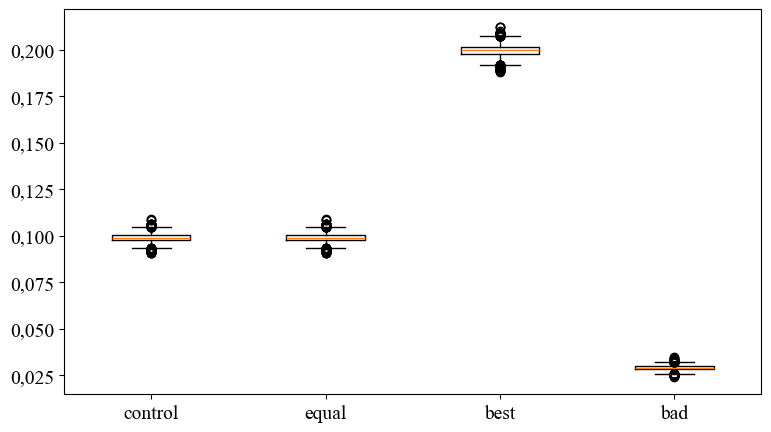

In [38]:
fig, ax = plt.subplots(figsize=(9, 5),)
plt.boxplot([control, equal,  best, bad, ], 
            labels=['control', 'equal', 'best', 'bad']);

### Решение (байесовский подход):
Необходимо наличие данных для формирования предположения о виде априоного распределения